Script to perform probabilistic hazard assessments on space weather GIC data from NERC



In [21]:
import numpy as np
import pandas as pd
import os, sys
import glob


from datetime import datetime, time

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter


import geopandas as gpd
from shapely.geometry import Point

import plotly.express as px

from scipy.integrate import trapz




### Functions

In [2]:
def clean_GIC_data(df,df_sensor_locations):
    '''
    - delete repeated time points
    - delete station if all time points are empty
    - Find how many of the measurements differ from one time step to the next and delete station if on average measurements differ less than once in 5 minutes
    - remove repeat stations from files
    - remove stations with an unacceptable level of bias
    
    '''
    
    # Delete repeated time points
    df = df.drop(df[df.duplicated(subset='datetimes', keep='first')].index)

    cols_to_drop1 = []
    cols_to_drop2 = []
    cols_to_drop3 = []
    
    
    # #NOTE THAT THIS DOES NOT WORK WELL SINCE I'M DROPPING MANY STATIONS THAT HAVE LOWER RESOLUTION DATA AND HAVE NANS FOR THE OTHER TIME STEPS THEY DO NOT RECORD
    # for id_loop in df.columns.to_list():
        
    #     if (id_loop == 'datetimes'):
    #         continue
            
    #     # Delete station if most time points are empty
    #     if ( (df[id_loop].isna().mean() * 100) > 80.):
    #         cols_to_drop1.append(id_loop)
    #         continue
            
    # print('\n \t cols_to_drop after first filter = {} \n'.format(cols_to_drop1))

    # remove repeat stations from files
    duplicate_lats = df_sensor_locations.duplicated(subset=' Latitude',keep='first')
    duplicate_lons = df_sensor_locations.duplicated(subset=' Longitude',keep='first')
    duplicate_locations = df_sensor_locations['Device ID'].values[np.where( (duplicate_lats.values==True) & (duplicate_lons.values==True) )]

    for d in duplicate_locations:
        try:
            #print(df[str(d)])
            cols_to_drop2.append(str(d))
        except:
            print('no df entry for devide ID {}'.format(str(d)))
#         # Check I wrote to guarantee the code above removes duplicate stations (keeping only one of the same lat-long)
#         for a in df_sensor_locations['Device ID'].values[np.where( (duplicate_lats.values==True) & (duplicate_lons.values==True) )]:
#             idx = df_sensor_locations.index[df_sensor_locations['Device ID'] == a].tolist()
#             print('the index of the duplicated lat and lon = {}'.format(a))
#             print(' \t --> {}'.format( df_sensor_locations[idx[0]-2:idx[0]+3] ))

    print('\n \t cols_to_drop after second filter = {} \n'.format(cols_to_drop2))

    # Find how many of the measurements differ from one time step to the next and delete station if measurements repeat for more than 60% of the data 
    for device_id in df.columns.to_list():
        if device_id == 'datetimes':
            continue
        count_zeros = np.count_nonzero(np.diff(df[device_id].values) == 0)
        tmp_len = len(np.argwhere(np.isfinite(df[device_id].values)==True))
        tmp = (count_zeros/tmp_len)*100
#             print('percentage of repeated values = {}'.format( tmp  ))
        if tmp > 60.:
            cols_to_drop3.append(device_id)

    print('\n \t cols_to_drop after third filter = {} \n'.format(cols_to_drop3))
  
    cols_to_drop_prefinal = list(set( cols_to_drop1 + cols_to_drop2 + cols_to_drop3 ))
    print('Total number of columns to drop = {}'.format(len(cols_to_drop_prefinal)))
#     # some stations were removed in the process of creating the integrated data files, so need to check if all columns to remove exist
    cols_to_drop_final = []
    for c in cols_to_drop_prefinal:
        if any( str(c) in x for x in df.columns.to_list()):
            cols_to_drop_final.append(str(c))
        else:
            print(' \t \t \t {} is NOT in the columns list'.format(c))

    df = df.drop(cols_to_drop_final,axis=1)

    print('\n Final number of columns retained: {}'.format(len(df.columns.to_list())))

    return df

In [10]:

def calculate_event_properties(eventID, sensorID, time_series, datetimes, threshold, min_consecutive_steps_event, min_consecutive_steps_eventbreak, positive_or_negative):
    '''
        eventID                             :               string identifying the event being analyzed
        sensorID                            :               string identifying the sensor being analyzed
        time_series                         :               the time series to be analyzed (GIC sensor readings)
        threshold                           :               level of GIC that determines an event
        min_consecutive_steps               :               number of consecutive time steps above threshold to define an event
        min_consecutive_steps_eventbreak    :               number of consecutive time steps below threshold to break an event
        positive_or_negative                :               'positive' if positive GIC values are to be examined, 'negative' if negative

    '''
    event_ctr = 0
    event_eventID = []
    event_sensorID = []
    event_start_idxs = []
    event_end_idxs = []
    event_start_times = []
    event_end_times = []
    event_sizes = []
    event_durations = []
    event_betweendistances = []
    start_idx = None
    end_idx = None
    area_under_curve = 0
#     event_duration = 0
#     event_distance = 0


    if positive_or_negative == 'positive':
        for i, value in enumerate(time_series):
                if value > threshold:
                    if start_idx is None:
                        start_idx = i
#                         print('start_idx = {}'.format(start_idx))
                    elif (end_idx is not None):
#                         if ( (i - end_idx) < min_consecutive_steps_eventbreak):
                        end_idx = None
            
                elif start_idx is not None:
                    if end_idx is None:
                        end_idx = i
#                         print('end_idx = {}'.format(end_idx))
                        
                    if ( (end_idx - start_idx) < min_consecutive_steps_event ) & ( (i - end_idx) >= min_consecutive_steps_eventbreak):
                        start_idx = None
                        continue
                    if ( ( end_idx - start_idx) >= min_consecutive_steps_event) & ( (i - end_idx) >= min_consecutive_steps_eventbreak): 
                        
                        event_ctr += 1
#                         print('\t i = {}, \n\t\t end_idx - start_idx = {} \n\t\t i-start_idx = {} \n\t\t i-end_idx = {}'.format (i, end_idx-start_idx, i - start_idx, i - end_idx))

                        event_eventID.append(eventID)
                        event_sensorID.append(sensorID)
        
                        event_start_idxs.append(start_idx)
                        event_end_idxs.append(end_idx)
                        event_start_times.append(datetimes.values[start_idx])
                        event_end_times.append(datetimes.values[end_idx])

                        # convert durations from indices to times
                        event_duration_time = ( pd.to_datetime(datetimes.values[end_idx]).to_pydatetime() -  pd.to_datetime(datetimes.values[start_idx]).to_pydatetime()  ).seconds

                        if event_ctr == 1:
                            event_betweendistance_time = np.nan
                        else: 
                            #difference between the start of the current event and the end of the previous event 
                            event_betweendistance_time = ( pd.to_datetime(datetimes.values[ event_start_idxs[event_ctr-1] ]).to_pydatetime() -  pd.to_datetime(datetimes.values[ event_end_idxs[event_ctr-2] ]).to_pydatetime()  ).seconds



                        event_durations.append(event_duration_time)
                        event_betweendistances.append(event_betweendistance_time)

                        # calculate the area under the event curve
                        time_series_event = time_series.values[start_idx:end_idx]
                        elaptimes_event = [(timestamp - pd.to_datetime(datetimes.values[start_idx]) ).total_seconds() for timestamp in pd.to_datetime(datetimes.values[start_idx:end_idx]) ]
                        valid_indices = np.isfinite(time_series_event)
                        elaptimes_valid = np.array(elaptimes_event)[valid_indices]
                        time_series_valid = time_series_event[valid_indices]

        #                 np.trapz(timeseries_valid[start_idx:end_idx], elaptimes_valid[start_idx:end_idx])
                        area_under_curve = trapz(time_series_valid-threshold, 
                                                 elaptimes_valid)
                        event_sizes.append(area_under_curve)

        #                 event_sizes.append(area_under_curve / event_duration)

                        start_idx = None
                        end_idx = None
                        area_under_curve = 0
                        event_duration_time = 0
                        event_betweendistance_time = 0 
                        elaptimes = []
                        valid_indices = []
                        elaptimes_valid = []
                        time_series_event = []
                        time_series_valid = []
            

                

    elif positive_or_negative == 'negative':
        threshold = threshold * -1.
        for i, value in enumerate(time_series):
            if value < threshold:
                if start_idx is None:
                    start_idx = i
#                         print('start_idx = {}'.format(start_idx))
                elif (end_idx is not None):
#                         if ( (i - end_idx) < min_consecutive_steps_eventbreak):
                    end_idx = None

            elif start_idx is not None:
                if end_idx is None:
                    end_idx = i
#                         print('end_idx = {}'.format(end_idx))

                if ( (end_idx - start_idx) < min_consecutive_steps_event ) & ( (i - end_idx) >= min_consecutive_steps_eventbreak):
                    start_idx = None
                    continue
                if ( ( end_idx - start_idx) >= min_consecutive_steps_event) & ( (i - end_idx) >= min_consecutive_steps_eventbreak): 

                    event_ctr += 1
#                         print('\t i = {}, \n\t\t end_idx - start_idx = {} \n\t\t i-start_idx = {} \n\t\t i-end_idx = {}'.format (i, end_idx-start_idx, i - start_idx, i - end_idx))

                    event_eventID.append(eventID)
                    event_sensorID.append(sensorID)

                    event_start_idxs.append(start_idx)
                    event_end_idxs.append(end_idx)
                    event_start_times.append(datetimes.values[start_idx])
                    event_end_times.append(datetimes.values[end_idx])

                    # convert durations from indices to times
                    event_duration_time = ( pd.to_datetime(datetimes.values[end_idx]).to_pydatetime() -  pd.to_datetime(datetimes.values[start_idx]).to_pydatetime()  ).seconds

                    if event_ctr == 1:
                        event_betweendistance_time = np.nan
                    else: 
                        #difference between the start of the current event and the end of the previous event 
                        event_betweendistance_time = ( pd.to_datetime(datetimes.values[ event_start_idxs[event_ctr-1] ]).to_pydatetime() -  pd.to_datetime(datetimes.values[ event_end_idxs[event_ctr-2] ]).to_pydatetime()  ).seconds



                    event_durations.append(event_duration_time)
                    event_betweendistances.append(event_betweendistance_time)

                    # calculate the area under the event curve
                    time_series_event = time_series.values[start_idx:end_idx]
                    elaptimes_event = [(timestamp - pd.to_datetime(datetimes.values[start_idx]) ).total_seconds() for timestamp in pd.to_datetime(datetimes.values[start_idx:end_idx]) ]
                    valid_indices = np.isfinite(time_series_event)
                    elaptimes_valid = np.array(elaptimes_event)[valid_indices]
                    time_series_valid = time_series_event[valid_indices]

    #                 np.trapz(timeseries_valid[start_idx:end_idx], elaptimes_valid[start_idx:end_idx])
                    area_under_curve = trapz( (time_series_valid*-1.) + threshold, 
                                             elaptimes_valid)
                    event_sizes.append(area_under_curve)

    #                 event_sizes.append(area_under_curve / event_duration)

                    start_idx = None
                    end_idx = None
                    area_under_curve = 0
                    event_duration_time = 0
                    event_betweendistance_time = 0 
                    elaptimes = []
                    valid_indices = []
                    elaptimes_valid = []
                    time_series_event = []
                    time_series_valid = []
            
            

#     # Convert the lists to pandas Series for easy analysis
#     events = pd.Series(events)
#     event_sizes = pd.Series(event_sizes)
#     event_durations = pd.Series(event_durations)
#     event_distances = pd.Series(event_distances)

    # convert to DF for easy analysis
    df_out = pd.DataFrame(columns=['event id',
                                   'sensor id',
                                   'event_start_idxs',
                                   'event_end_idxs',
                                   'event_start_times',
                                   'event_end_times',
                                   'event_sizes',
                                   'event_durations',
                                   'event_betweendistances'])
    df_out['event id'] = event_eventID
    df_out['sensor id'] = event_sensorID
    df_out['event_start_idxs'] = event_start_idxs
    df_out['event_end_idxs'] = event_end_idxs
    df_out['event_start_times'] = event_start_times
    df_out['event_end_times'] = event_end_times
    df_out['event_sizes'] = event_sizes
    df_out['event_durations'] = event_durations
    df_out['event_betweendistances'] = event_betweendistances
    

    return df_out

In [3]:
from IPython.display import IFrame

# Display the HTML file in an iframe
IFrame(src="Reliability Coordination Regions.html", width=800, height=600)

In [4]:
# Load regions
regions_gdf = gpd.read_file("/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/NERC_Reliability_Coordinators.geojson")
# Ensure the CRS is WGS84 (EPSG:4326)
if regions_gdf.crs is None or regions_gdf.crs.to_string() != "EPSG:4326":
    print('converting to EPSG: 4326')
    regions_gdf = regions_gdf.to_crs("EPSG:4326")


In [69]:

# Histogram initializations
    # Define the histogram bins between -50 and 50
bins = np.linspace(-50, 50, num=101)  # 101 edges for 100 bins
bin_centers = (bins[:-1] + bins[1:]) / 2  # Calculate bin centers for plotting later

    # Initialize an empty dictionary to store histograms for each region
histogram_data = {}
extreme_value_data = {}


# Bursts initializations
threshold_GIC = 1.5
min_consecutive_steps_event = 10 # must remain above threshold for X consecutive time steps to be an event
min_consecutive_steps_eventbreak = 6 # must fall below threshold for X consecutive time steps to end an event

regions_tmp = ['CALIFORNIA INDEPENDENT SYSTEM OPERATOR',
           'MIDCONTINENT INDEPENDENT SYSTEM OPERATOR, INC..',
           'SOUTHWEST POWER POOL', 'PJM INTERCONNECTION, LLC', 
           'ERCOT ISO', 'SOUTHERN COMPANY SERVICES, INC.',
           'TENNESSEE VALLEY AUTHORITY', 'VACAR SOUTH', 
           'ISO NEW ENGLAND INC.', 'NEW YORK INDEPENDENT SYSTEM OPERATOR',
           'FLORIDA RELIABILITY COORDINATING COUNCIL',
           'NEW BRUNSWICK POWER CORPORATION', 'SOUTHWEST POWER POOL WEST']

keys_tmp = ['event_start_idxs', 'event_end_idxs', 'event_start_times',  
        'event_end_times', 'event_sizes', 'event_durations', 
        'event_betweendistances']

bursts_events_data = {region: {key: [] for key in keys_tmp} for region in regions_tmp}




# Load integrated data files
integrated_data_directory = '/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/integrated_data/'
files = glob.glob( os.path.join(integrated_data_directory,'*.csv') )


# Identify an event (later can loop over these to grow statistics)
event_idx = 17

for f in files:#[event_idx:event_idx+1]:

    # read in the numerical data for the sensors in this event
    df = pd.read_csv(f,index_col=False)
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns='Unnamed: 0')

    # read in the lat-long values for the sensors in this event
    print('\n\n\n\n----------------------------\nworking on event: {}'.format(f[97:-4])) #f.find('event')
    print('\t--->{}'.format(f))
    file_sensor_locations = os.path.join('/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/','risk-resiliency-spwx','data',f[97:-4],'GIC','gic_monitors.csv')

    print('\t--->{}'.format(file_sensor_locations))
    df_sensor_locations = pd.read_csv(file_sensor_locations)
    df_sensor_locations[' Longitude'] = df_sensor_locations[' Longitude'] * -1.

    # Convert sensor DataFrame to GeoDataFrame
    gdf_sensor_locations = gpd.GeoDataFrame(
                                df_sensor_locations,
                                geometry=[Point(xy) for xy in zip(df_sensor_locations[" Longitude"], df_sensor_locations[" Latitude"])],
                                crs="EPSG:4326"
                                )
    # Drop unwanted columns
    cols_to_drop_loc = df.columns.get_loc('AE_INDEX')
    df = df.drop(df.columns.to_list()[cols_to_drop_loc:],axis = 1)
    try: 
        df = df.drop('10701')
    except: 
        print('df does not have device ID 10701 to drop')
    
    # Clean the data
    df = clean_GIC_data(df,df_sensor_locations)

    


    # Perform Spatial Join with NERC Reliability Regions
    sensor_locations_with_regions = gpd.sjoin(gdf_sensor_locations, regions_gdf, how="left", predicate="within")
    sensor_locations_with_regions = sensor_locations_with_regions.reset_index()
    sensor_locations_with_regions = sensor_locations_with_regions.drop_duplicates(subset="index",keep="first")
    sensor_locations_with_regions = sensor_locations_with_regions.drop(columns=["index"])

    df_sensor_locations["Region"] = sensor_locations_with_regions["NAME"]

    grouped = df_sensor_locations.groupby('Region')
    for region, region_data in grouped:

        # Initialize histogram for this region if not already present
        if region not in histogram_data:
            histogram_data[region] = np.zeros(len(bins) - 1)
            extreme_value_data[region] = []#np.array(())

        
        # Loop over each 'Device ID' in the region
        for device_id, device_data in region_data.groupby('Device ID'):
            # Get counts for this 'Device ID' in the histogram bins
            try:
                device_data = df[str(device_id)]
            except:
                print('missing device ID = {}, continuing...'.format(device_id))
                continue
            counts, _ = np.histogram(device_data.values, bins=bins)
            max_val_device = np.nanmax(device_data.values)
            
            # Add these counts to the region's histogram
            histogram_data[region] += counts
            extreme_value_data[region].append(max_val_device)

            # Calculate bursts 
            for sign_GIC in ['positive','negative']:
                df_bursts = pd.DataFrame(columns=['event_start_idxs',
                                                   'event_end_idxs',
                                                   'event_start_times',
                                                   'event_end_times',
                                                   'event_sizes',
                                                   'event_durations',
                                                   'event_betweendistances'])
                df_bursts_device = calculate_event_properties(f[97:-4], device_id, device_data, df['datetimes'], threshold_GIC, min_consecutive_steps_event,  min_consecutive_steps_eventbreak,sign_GIC)
                df_bursts = pd.concat([df_bursts, df_bursts_device], axis=0)
                # wait = input("Press Enter to continue.")

            # Add these bursts data to the region's dictionary
            for k in keys_tmp:
                # bursts_events_data[region][k].append(df_bursts[k].values)
                bursts_events_data[region][k] += df_bursts[k].values.tolist()

    







----------------------------
working on event: event_20150919
	--->/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/integrated_data/integrated_data_event_20150919.csv
	--->/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx/data/event_20150919/GIC/gic_monitors.csv
df does not have device ID 10701 to drop

 	 cols_to_drop after second filter = ['10224', '10300', '10320', '10258', '10259', '10260', '10262', '10263', '10264', '10295', '10360', '10361', '10364', '10399', '10400', '10401', '10403', '10405', '10406', '10407', '10410', '10411', '10412', '10413', '10327', '10378', '10379', '10380', '10382', '10383', '10385', '10387', '10388', '10433', '10436'] 


 	 cols_to_drop after third filter = ['10200', '10412', '10406', '10361', '10407', '10413', '10405', '10411', '10388', '10410', '10404', '10362', '10400', '10399', '10401', '10402', '10364', '10276', '10076', '10300', '10301', '10305', '10299', '10306', '10083', '10322', '10309', '

In [56]:
print(f"Data min: {np.min(histogram)}, Data max: {np.max(histogram)}")

Data min: 0.0, Data max: 176308.0


### Probabilistic Hazard Assessment

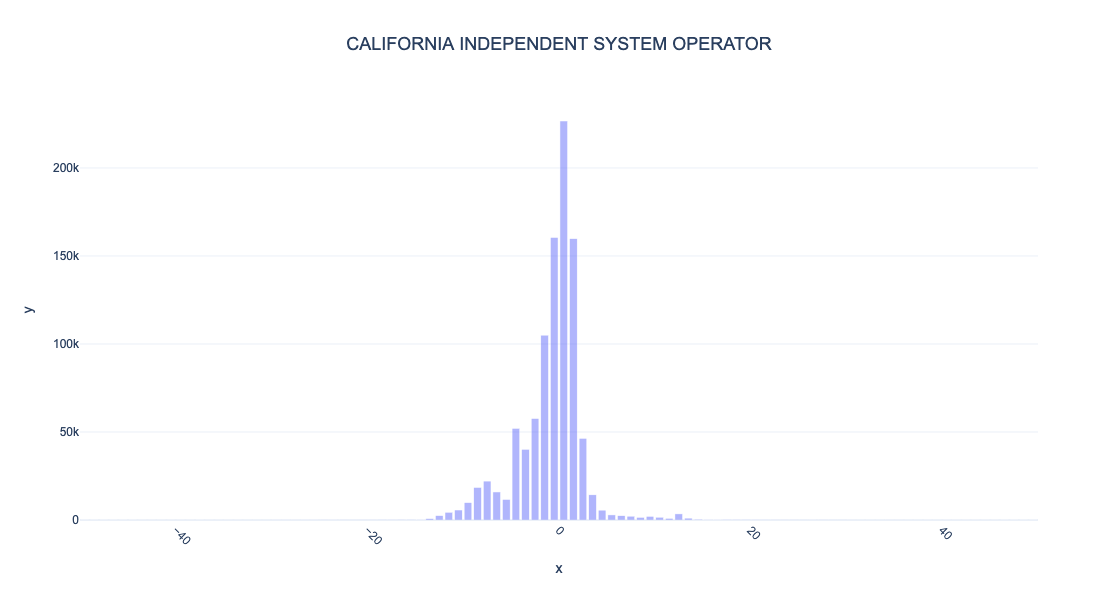

GEV Parameters for region CALIFORNIA INDEPENDENT SYSTEM OPERATOR:
Shape: -0.4617754827210815, Location: 1.9980427977390118, Scale: 5.148303106731991


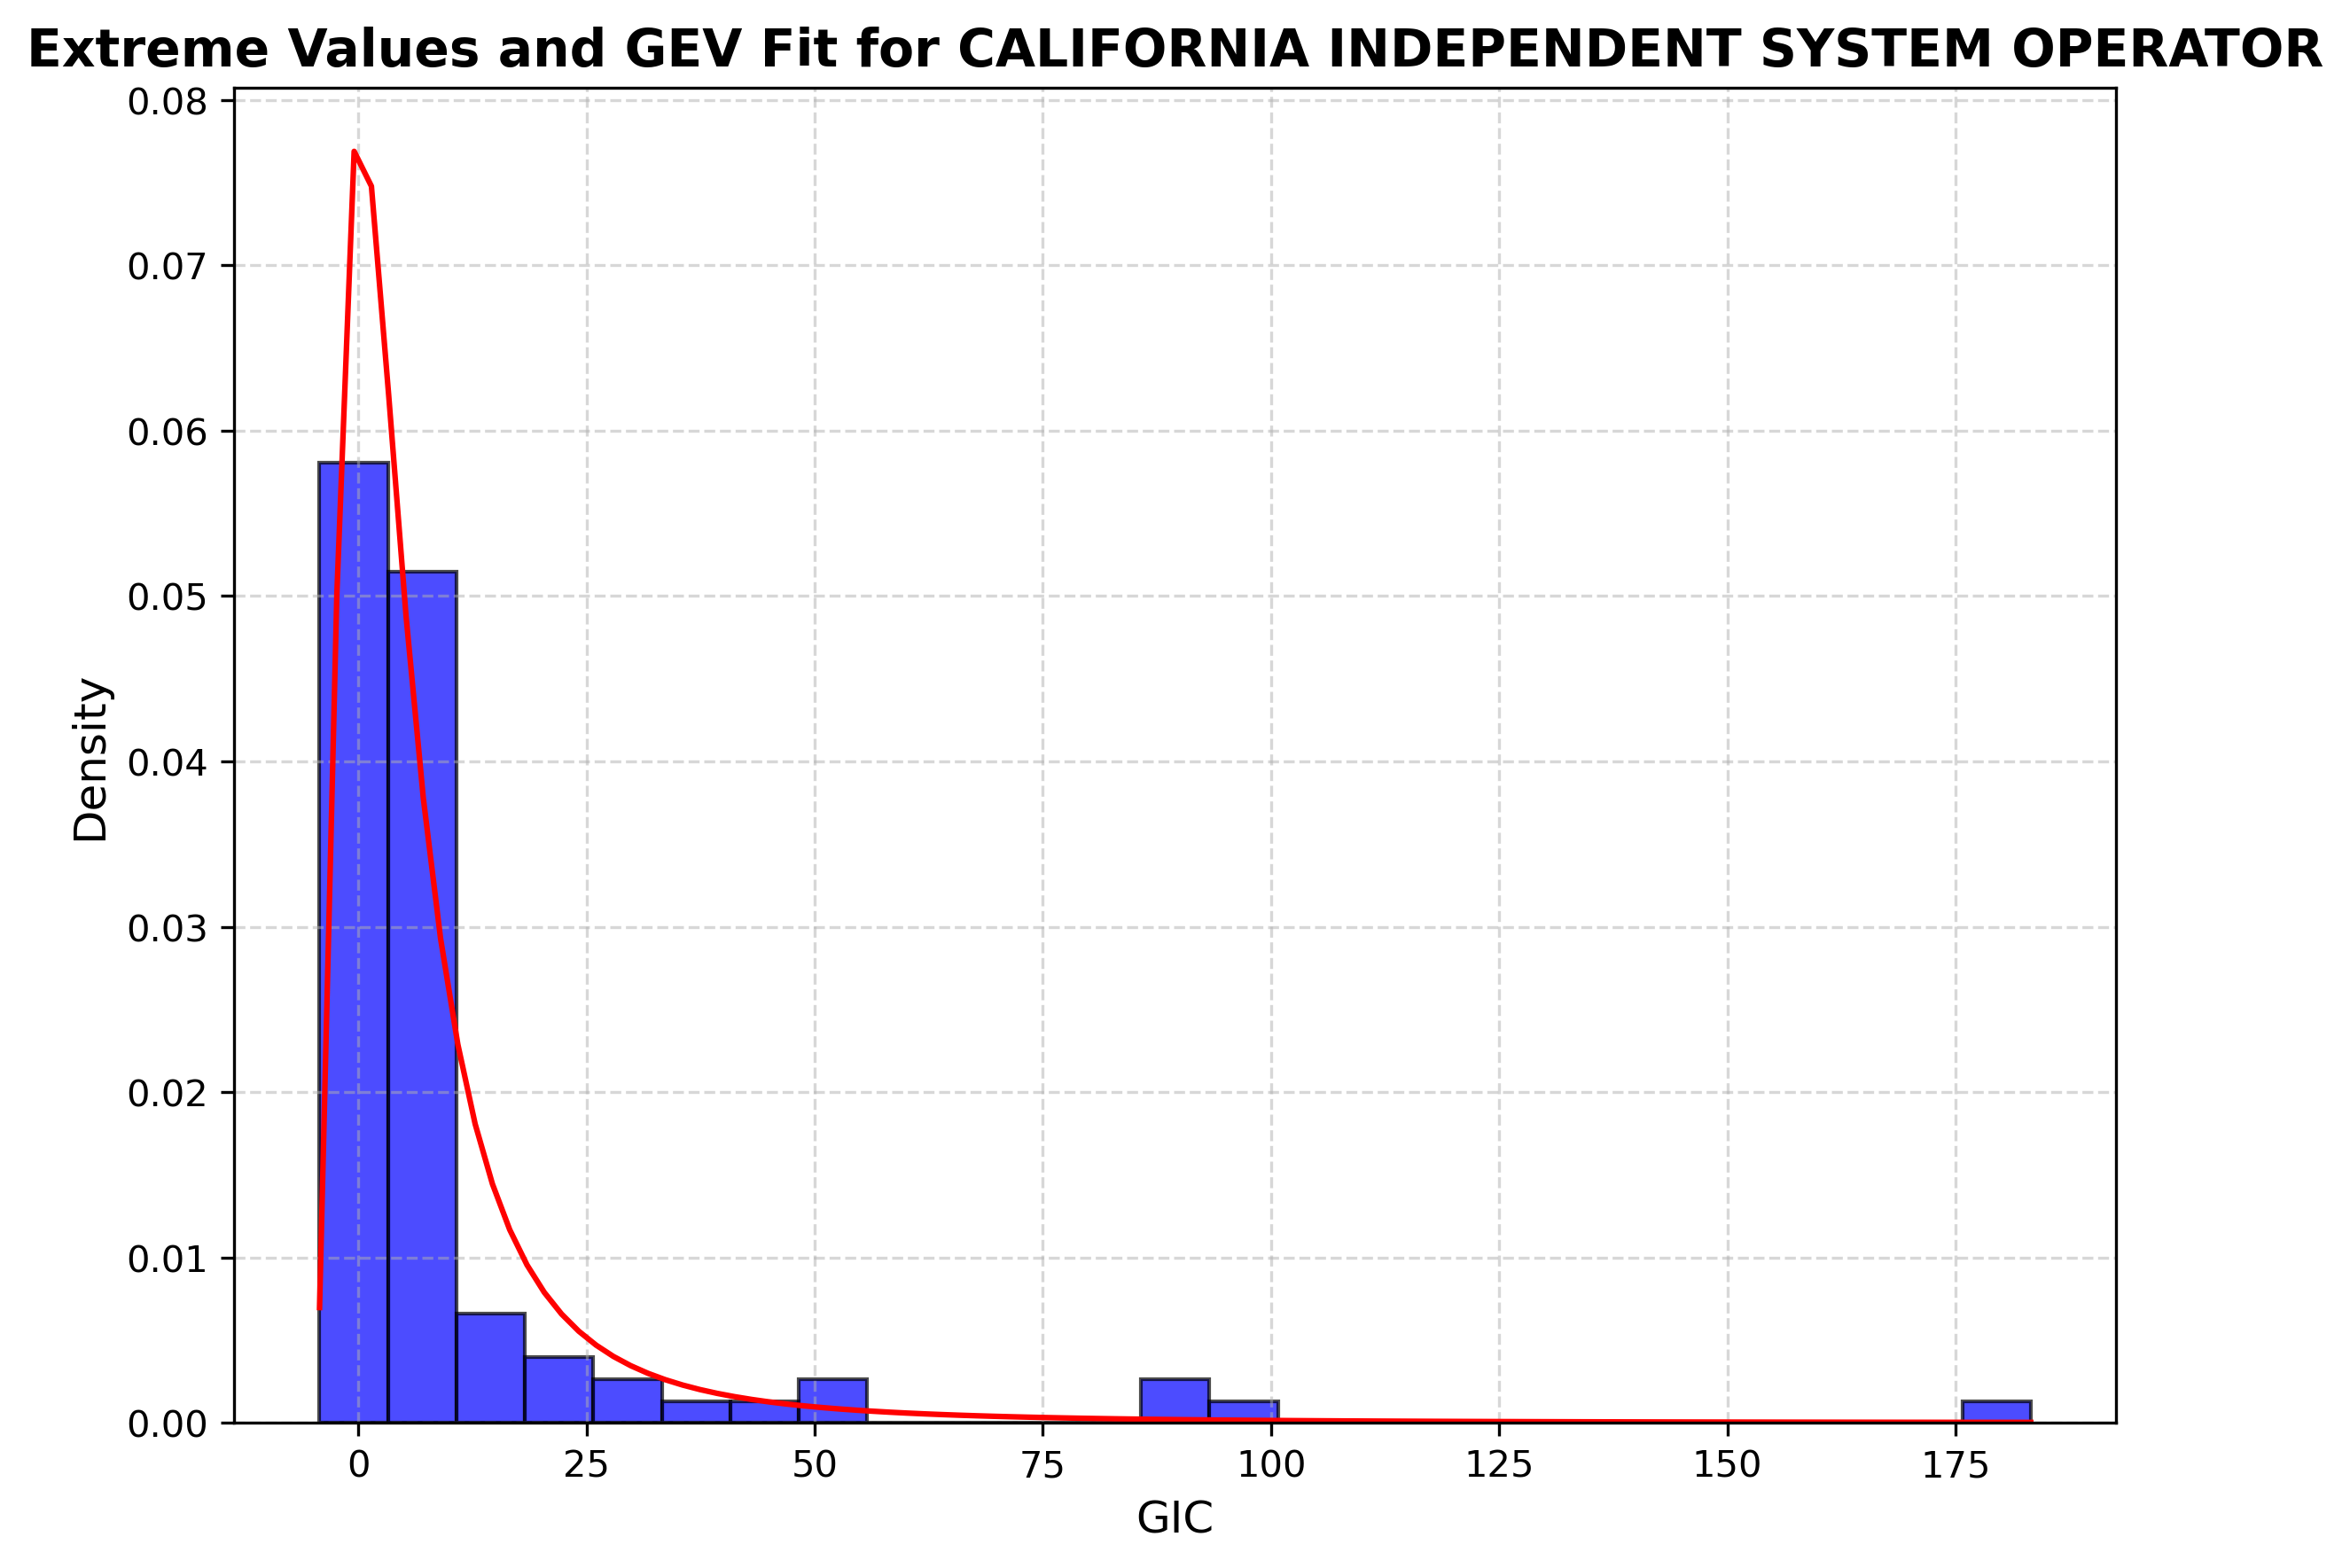

Return Period for region CALIFORNIA INDEPENDENT SYSTEM OPERATOR: 10 years, Return Level: 22.37
Return Period for region CALIFORNIA INDEPENDENT SYSTEM OPERATOR: 20 years, Return Level: 34.79
Return Period for region CALIFORNIA INDEPENDENT SYSTEM OPERATOR: 50 years, Return Level: 58.42
Return Period for region CALIFORNIA INDEPENDENT SYSTEM OPERATOR: 100 years, Return Level: 84.13


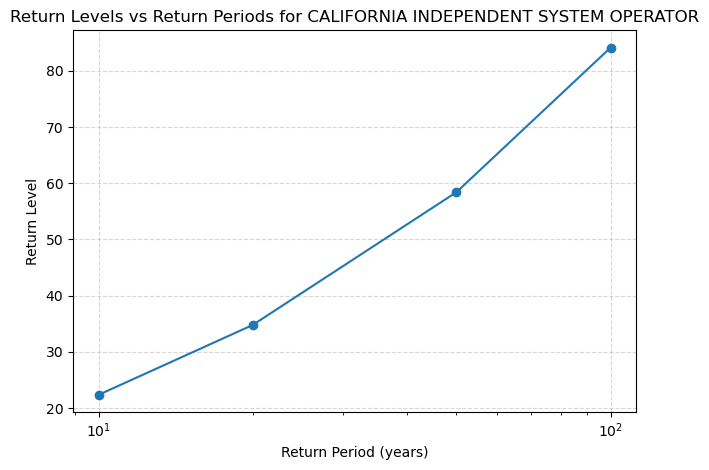

In [70]:
# choose a region and do full PHA

# Step One: plot histogram
key = 'CALIFORNIA INDEPENDENT SYSTEM OPERATOR'
data_pha = histogram_data[key]
# data_eva = extreme_value_data[key]

# Convert data to a Pandas DataFrame for use with Plotly
df_pha = pd.DataFrame({key: data_pha})

# Create a histogram using Plotly Express
fig = px.bar(
        df_pha,
        x=bin_centers, 
        y=data_pha,
        title=key,
        template="plotly_white",
        labels={"GIC values", "Frequency"},
        opacity=0.5  # 50% transparent bars
    )

# Customize the layout for publication quality
fig.update_layout(
    title=dict(font=dict(size=18, family="Arial"), x=0.5),
    xaxis=dict(title=dict(font=dict(size=14)), tickangle=45),
    yaxis=dict(title=dict(font=dict(size=14))),
    font=dict(size=12, family="Arial"),
    width=800,
    height=600
)
# fig.update_yaxes(type="log")

# Show the figure
fig.show()

# Step two: fit a GEV distribution

plt.figure(figsize=(8, 6), dpi=300)
for region, e in extreme_value_data.items():

    if region == key:
        gev_params = genextreme.fit(e)
        
        # Extract GEV parameters
        shape, loc, scale = gev_params
        print(f"GEV Parameters for region {region}:\nShape: {shape}, Location: {loc}, Scale: {scale}")
        extreme_value_fits[region] = [shape,loc,scale]
        
        # Generate x values for plotting
        x = np.linspace(min(e), max(e), 100)
        
        # Compute the PDF of the fitted GEV distribution
        pdf = genextreme.pdf(x, shape, loc=loc, scale=scale)
        
        # Plot histogram and GEV PDF
        plt.hist(e, bins=25, density=True, alpha=0.7, color='blue', edgecolor='black', label='Empirical Data')
        plt.plot(x, pdf, 'r-', label='GEV Fit')
        plt.title('Extreme Values and GEV Fit for '+region, fontsize=14, fontweight="bold")
        
        plt.xlabel('GIC', fontsize=12)
        plt.ylabel('Density', fontsize=12)

        # Grid and legend
        plt.grid(visible=True, linestyle="--", alpha=0.5)
        
        # Tight layout for better spacing
        plt.tight_layout()
        plt.savefig("/Users/ryanmc/Documents/Conferences/AGU2024/poster_figures/risk_science/eva_gev.png", format="png", dpi=300)
        
        # Show the figure
        plt.show()


# Step three: get return periods
for region, e in extreme_value_fits.items():
    if region == key:
        # Define return periods (in years)
        return_periods = np.array([10, 20, 50, 100])
        
        # Calculate return levels
        return_levels = genextreme.isf(1 / return_periods, e[0], loc=e[1], scale=e[2])
        
        # Display results
        for rp, rl in zip(return_periods, return_levels):
            print(f"Return Period for region {region}: {rp} years, Return Level: {rl:.2f}")
    
    
        plt.figure()
        plt.plot(return_periods, return_levels, marker='o', label='Return Levels')
        plt.title('Return Levels vs Return Periods for '+region)
        plt.xlabel('Return Period (years)')
        plt.ylabel('Return Level')
        plt.xscale('log')  # Log scale for better visualization
        
        # Grid and legend
        plt.grid(visible=True, linestyle="--", alpha=0.5)
        
        # Tight layout for better spacing
        plt.tight_layout()
        plt.savefig("/Users/ryanmc/Documents/Conferences/AGU2024/poster_figures/risk_science/return_periods.png", format="png", dpi=300)
        
        # Show the figure
        plt.show()

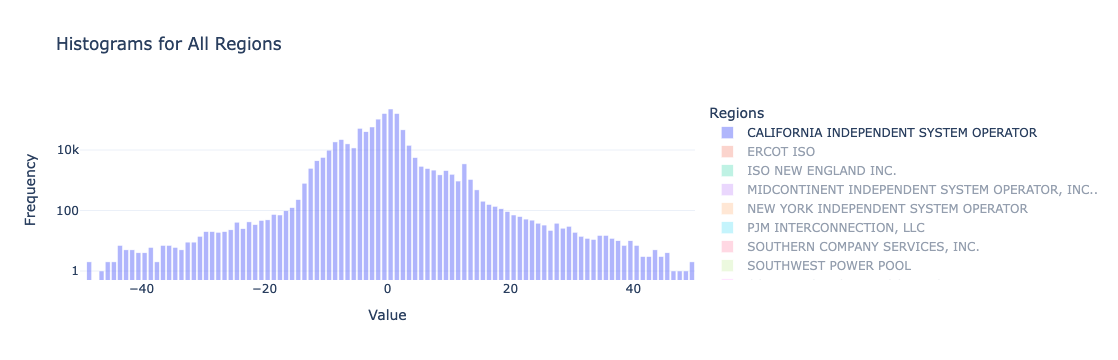

In [51]:
import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Add traces for each region
for region, histogram in histogram_data.items():
    fig.add_trace(
        go.Bar(
            x=bin_centers, 
            y=histogram,
            name=region,
            opacity=0.5  # 50% transparent bars
        )
    )

# Update layout to add interactivity and labels
fig.update_layout(
    title="Histograms for All Regions",
    xaxis_title="Value",
    yaxis_title="Frequency",
    barmode="overlay",  # Overlay bars instead of stacking
    legend_title="Regions",
    template="plotly_white"
)
fig.update_yaxes(type="log")

# Show the interactive plot
fig.show()

In [72]:
histogram_data

{'CALIFORNIA INDEPENDENT SYSTEM OPERATOR': array([0.000000e+00, 2.000000e+00, 0.000000e+00, 7.000000e+00,
        2.000000e+00, 1.200000e+01, 7.000000e+00, 5.000000e+00,
        6.000000e+00, 6.000000e+00, 5.000000e+00, 1.300000e+01,
        3.000000e+00, 1.000000e+01, 8.000000e+00, 7.000000e+00,
        2.000000e+01, 1.500000e+01, 1.000000e+01, 1.800000e+01,
        2.800000e+01, 2.200000e+01, 2.100000e+01, 2.400000e+01,
        3.900000e+01, 4.400000e+01, 3.800000e+01, 6.900000e+01,
        4.900000e+01, 9.300000e+01, 8.400000e+01, 9.600000e+01,
        1.330000e+02, 1.800000e+02, 2.200000e+02, 2.920000e+02,
        9.050000e+02, 2.642000e+03, 4.632000e+03, 5.923000e+03,
        1.018800e+04, 2.761200e+04, 4.606200e+04, 1.870700e+04,
        3.645900e+04, 2.034900e+05, 4.813280e+05, 1.173918e+06,
        2.545246e+06, 1.765060e+06, 3.234344e+06, 2.168103e+06,
        8.642170e+05, 1.132831e+06, 9.266880e+05, 4.160780e+05,
        8.006600e+04, 1.815100e+04, 9.332000e+03, 2.856000e+03

### Extreme Value Analyses

In [30]:
from scipy.stats import genextreme, genpareto
from pyextremes import get_return_periods

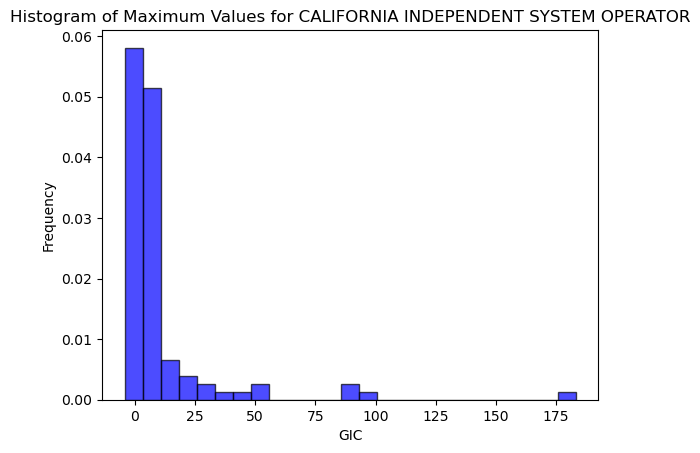

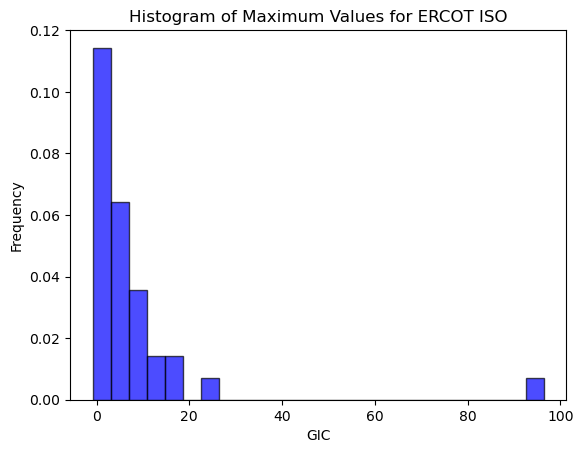

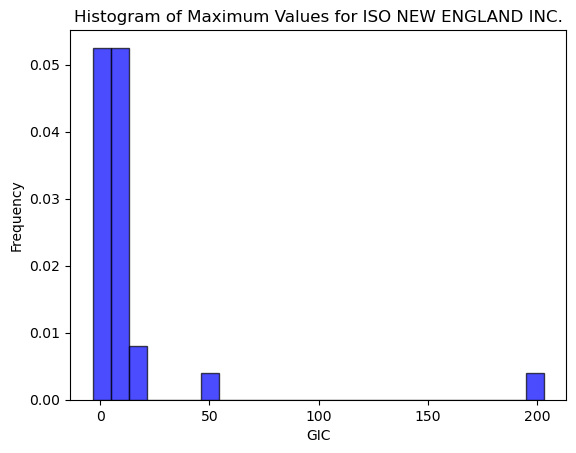

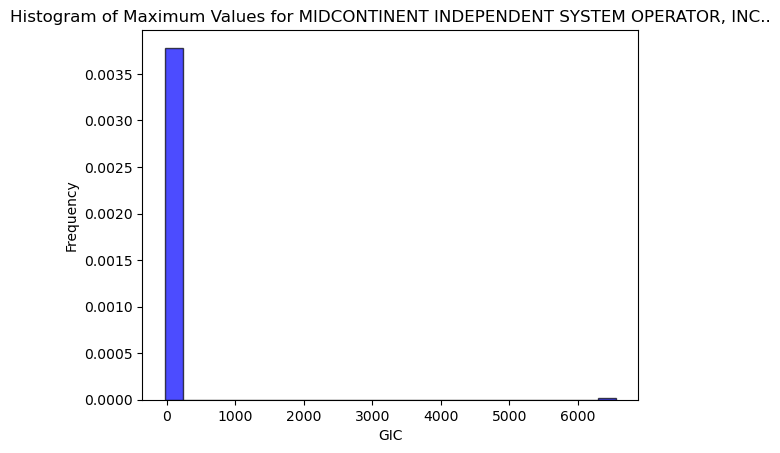

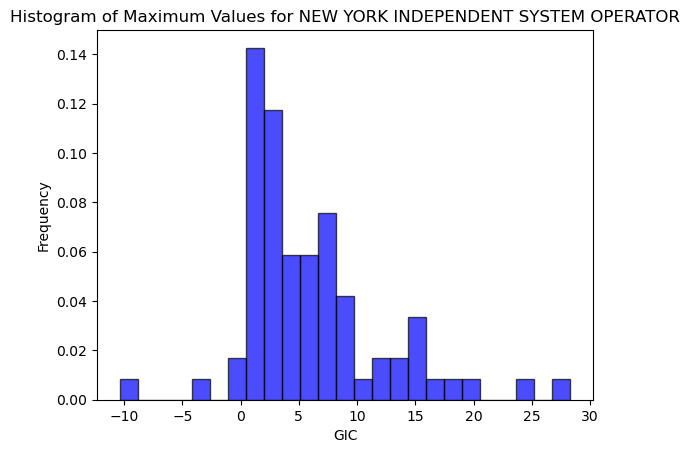

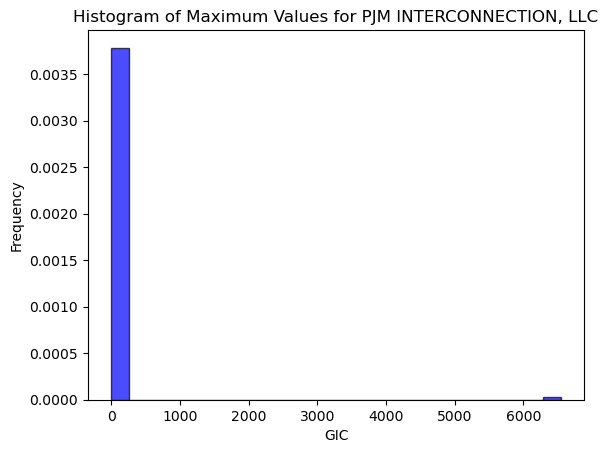

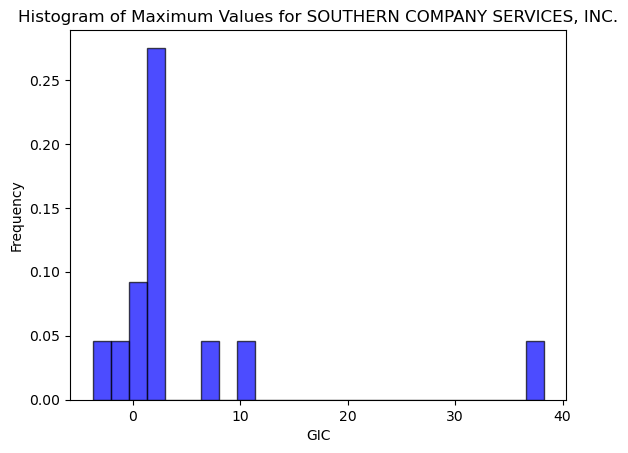

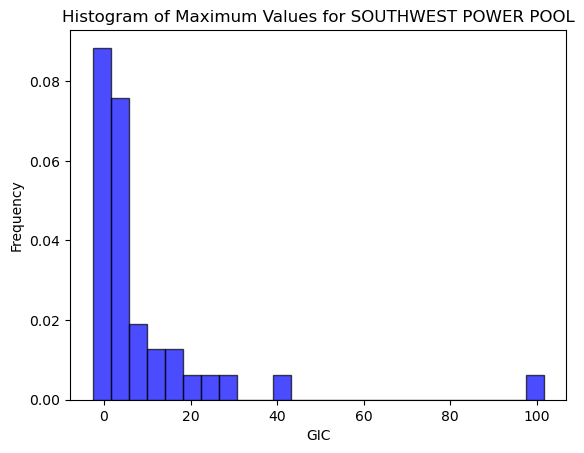

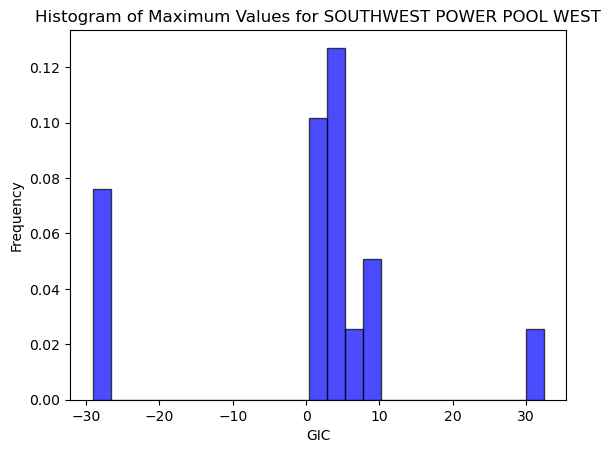

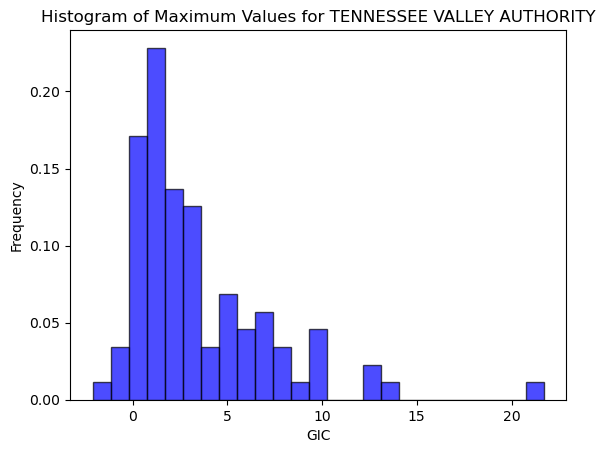

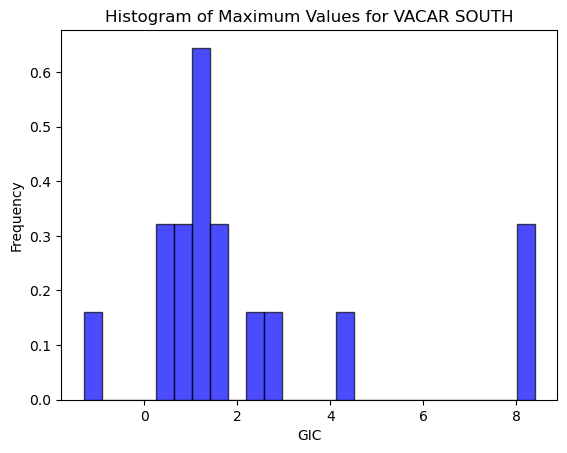

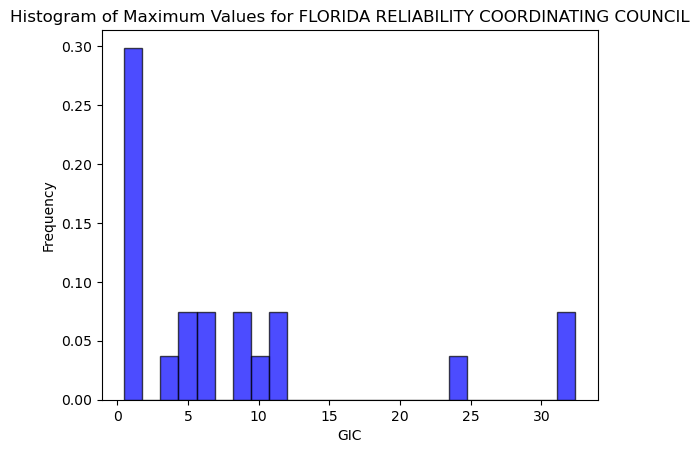

In [31]:
for region, data in extreme_value_data.items():
    plt.figure()
    plt.hist
    plt.hist(data, bins=25, density=True, alpha=0.7, color='blue', edgecolor='black')
    plt.title('Histogram of Maximum Values for '+region)
    plt.xlabel('GIC')
    plt.ylabel('Frequency')
    plt.show()



GEV Parameters for region CALIFORNIA INDEPENDENT SYSTEM OPERATOR:
Shape: -0.4617754827210815, Location: 1.9980427977390118, Scale: 5.148303106731991


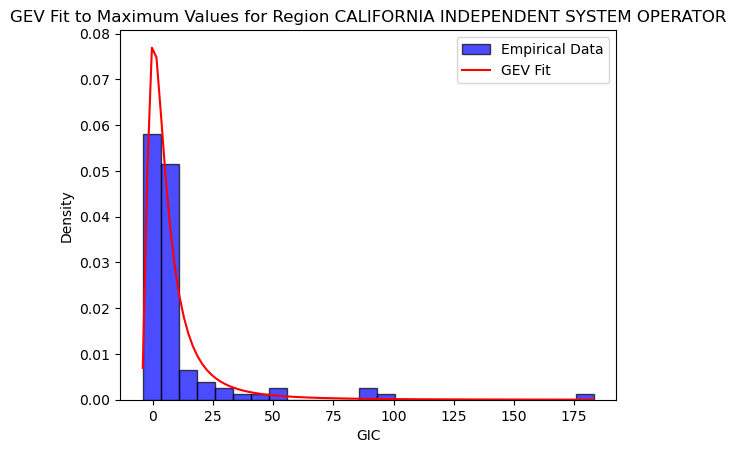

GEV Parameters for region ERCOT ISO:
Shape: -0.5202765330426034, Location: 2.679091056804248, Scale: 3.241636798623011


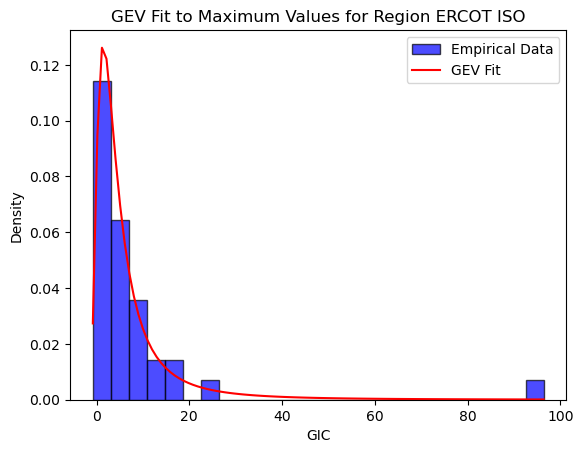

GEV Parameters for region ISO NEW ENGLAND INC.:
Shape: -0.4844702835987261, Location: 2.1116568257672794, Scale: 5.396057785996445


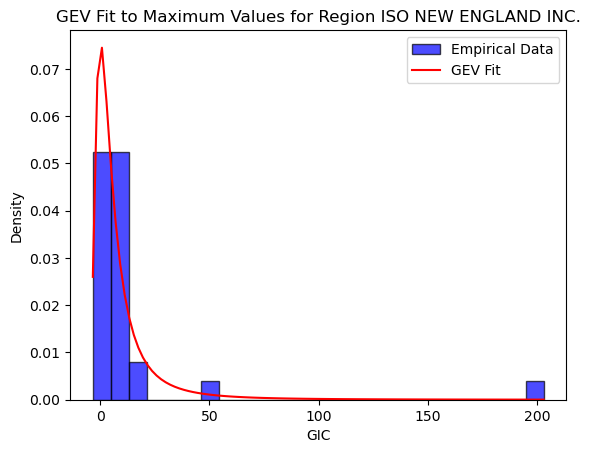

GEV Parameters for region MIDCONTINENT INDEPENDENT SYSTEM OPERATOR, INC..:
Shape: -0.11279459084656093, Location: 3.137489242788728, Scale: 10.983946527658023


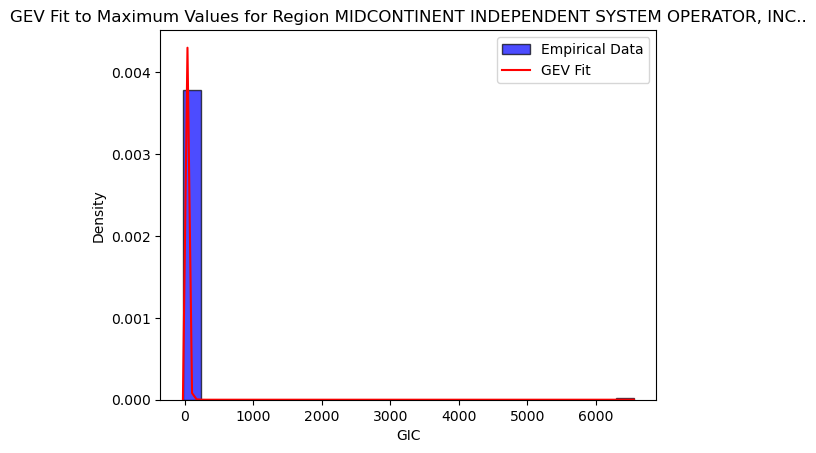

GEV Parameters for region NEW YORK INDEPENDENT SYSTEM OPERATOR:
Shape: 0.089043346677807, Location: 3.442501747415821, Scale: 5.230377443032219


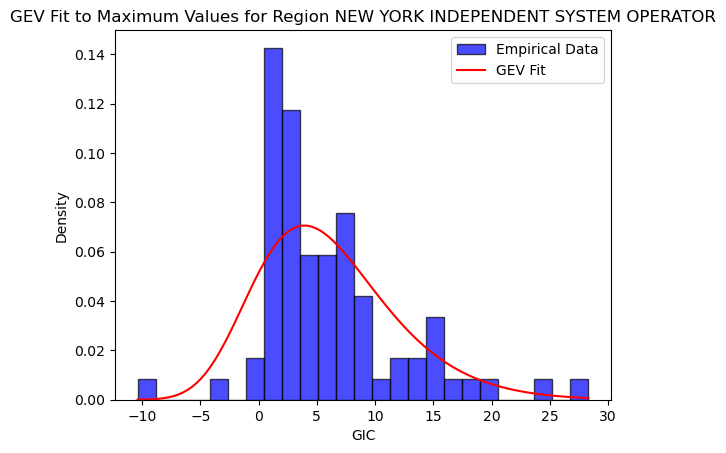

GEV Parameters for region PJM INTERCONNECTION, LLC:
Shape: -0.28094982762745346, Location: 3.390548055728499, Scale: 5.365107060054733


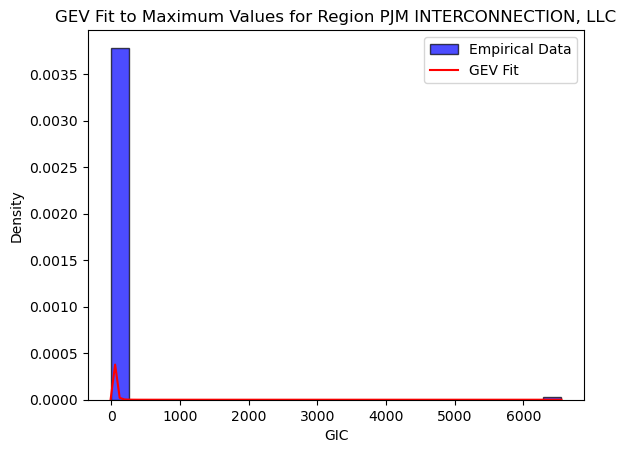

GEV Parameters for region SOUTHERN COMPANY SERVICES, INC.:
Shape: -0.29807531379018404, Location: 0.9480158466417483, Scale: 3.9759885318200205


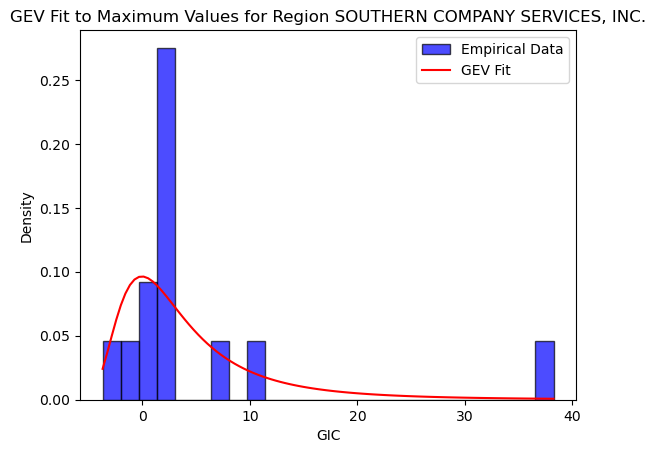

GEV Parameters for region SOUTHWEST POWER POOL:
Shape: -0.5234964794775743, Location: 1.9634658403194973, Scale: 3.8884049140470864


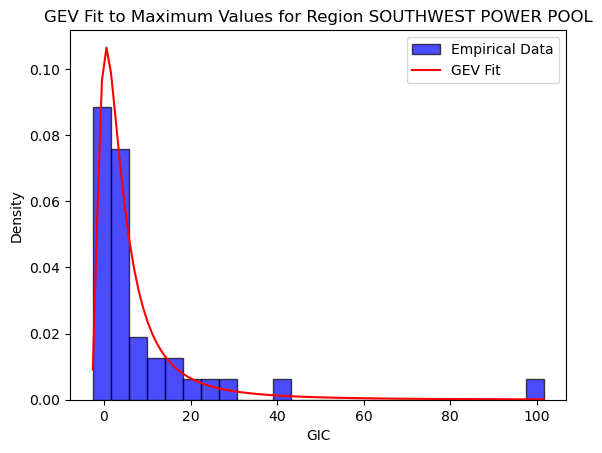

GEV Parameters for region SOUTHWEST POWER POOL WEST:
Shape: 3.1928797170350025, Location: 30.468904486313697, Scale: 6.165755697306284


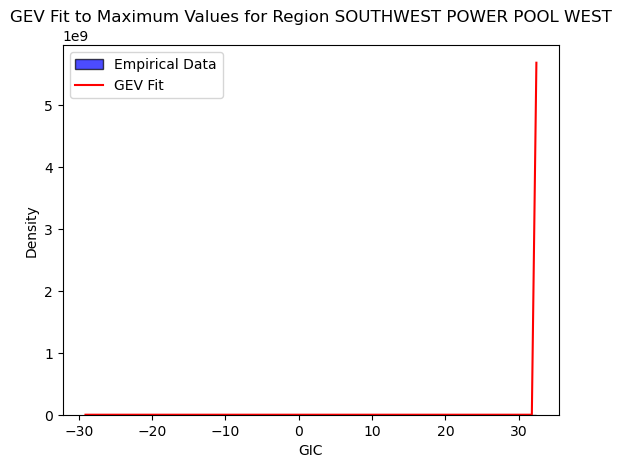

GEV Parameters for region TENNESSEE VALLEY AUTHORITY:
Shape: -0.17840700250181246, Location: 1.6886159592695025, Scale: 2.20920684931578


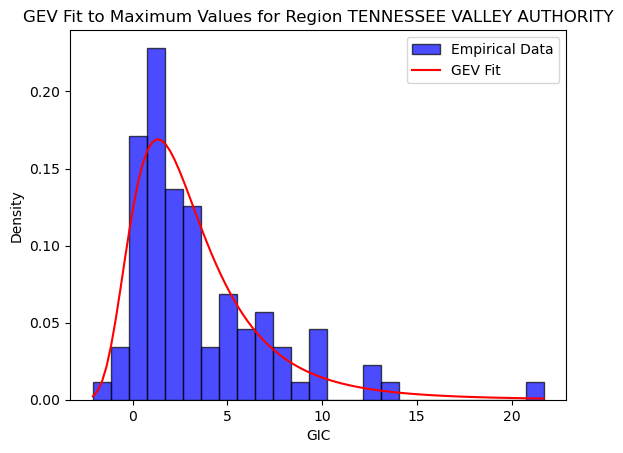

GEV Parameters for region VACAR SOUTH:
Shape: -0.1342339123706116, Location: 0.990036035750514, Scale: 1.6307249460414077


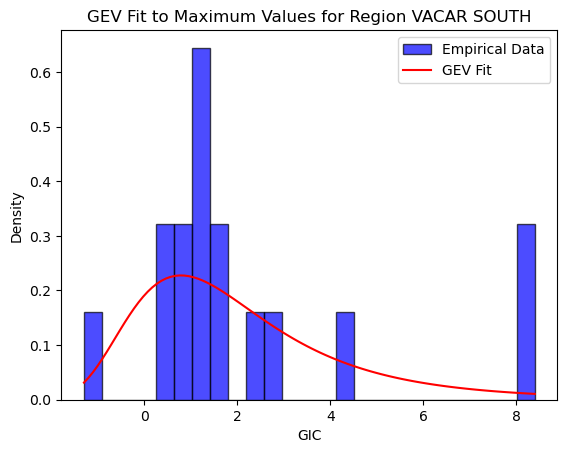

GEV Parameters for region FLORIDA RELIABILITY COORDINATING COUNCIL:
Shape: -1.810433246327205, Location: 1.4197394961939502, Scale: 1.8043763353611233


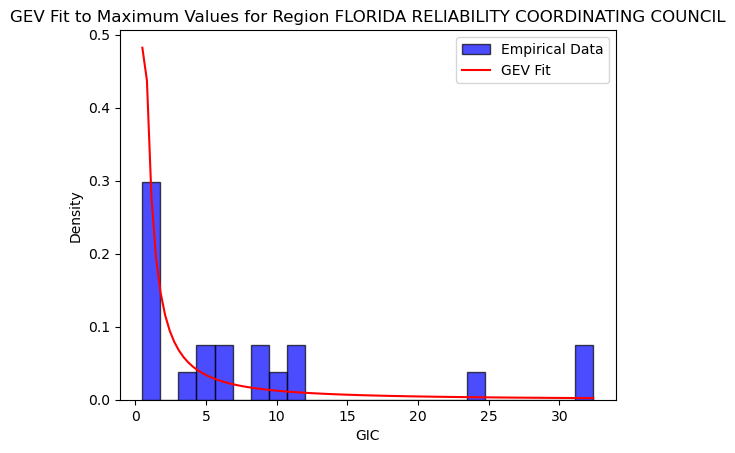

In [32]:
extreme_value_fits = {}
for region, e in extreme_value_data.items():

    if region not in extreme_value_fits:
        extreme_value_fits[region] = 0
    # Fit a Generalized Extreme Value (GEV) distribution
    gev_params = genextreme.fit(e)
    
    # Extract GEV parameters
    shape, loc, scale = gev_params
    print(f"GEV Parameters for region {region}:\nShape: {shape}, Location: {loc}, Scale: {scale}")
    extreme_value_fits[region] = [shape,loc,scale]
    
    # Generate x values for plotting
    x = np.linspace(min(e), max(e), 100)
    
    # Compute the PDF of the fitted GEV distribution
    pdf = genextreme.pdf(x, shape, loc=loc, scale=scale)
    
    # Plot histogram and GEV PDF
    plt.hist(e, bins=25, density=True, alpha=0.7, color='blue', edgecolor='black', label='Empirical Data')
    plt.plot(x, pdf, 'r-', label='GEV Fit')
    plt.title('GEV Fit to Maximum Values for Region '+region)
    plt.xlabel('GIC')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    

Return Period for region CALIFORNIA INDEPENDENT SYSTEM OPERATOR: 10 years, Return Level: 22.37
Return Period for region CALIFORNIA INDEPENDENT SYSTEM OPERATOR: 20 years, Return Level: 34.79
Return Period for region CALIFORNIA INDEPENDENT SYSTEM OPERATOR: 50 years, Return Level: 58.42
Return Period for region CALIFORNIA INDEPENDENT SYSTEM OPERATOR: 100 years, Return Level: 84.13


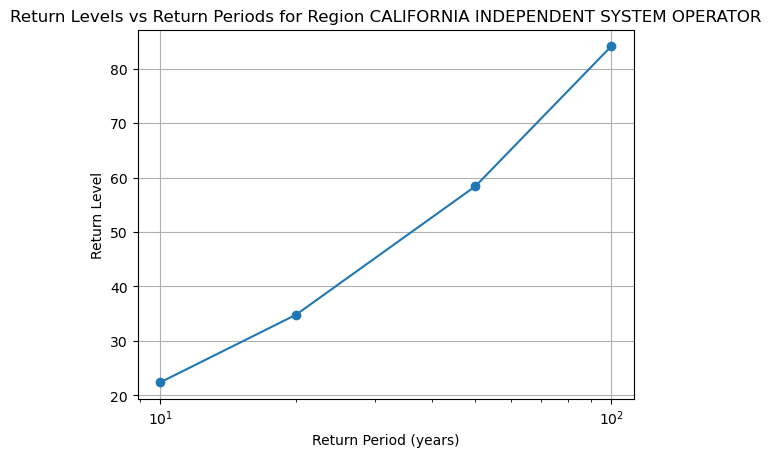

Return Period for region ERCOT ISO: 10 years, Return Level: 16.54
Return Period for region ERCOT ISO: 20 years, Return Level: 25.67
Return Period for region ERCOT ISO: 50 years, Return Level: 43.89
Return Period for region ERCOT ISO: 100 years, Return Level: 64.67


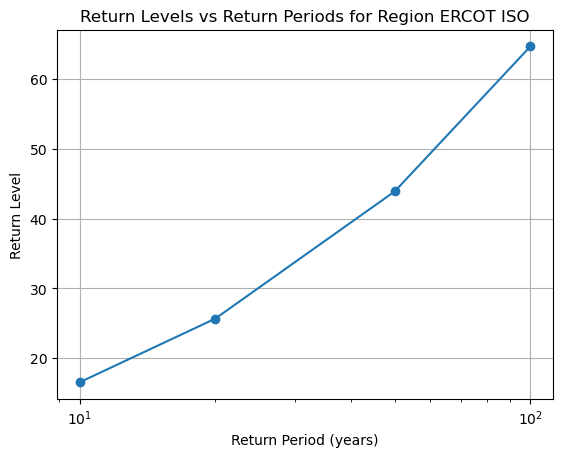

Return Period for region ISO NEW ENGLAND INC.: 10 years, Return Level: 24.11
Return Period for region ISO NEW ENGLAND INC.: 20 years, Return Level: 37.94
Return Period for region ISO NEW ENGLAND INC.: 50 years, Return Level: 64.73
Return Period for region ISO NEW ENGLAND INC.: 100 years, Return Level: 94.41


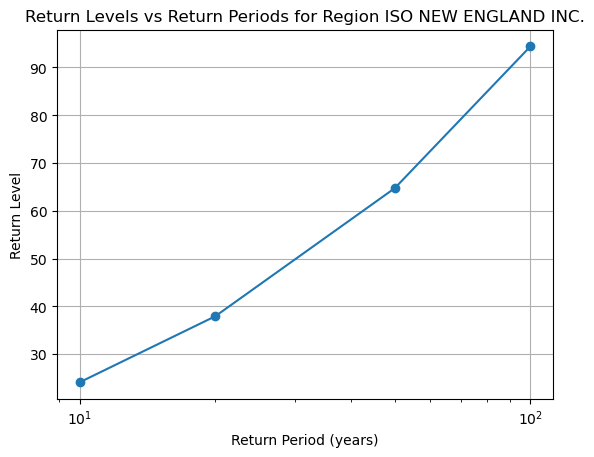

Return Period for region MIDCONTINENT INDEPENDENT SYSTEM OPERATOR, INC..: 10 years, Return Level: 31.28
Return Period for region MIDCONTINENT INDEPENDENT SYSTEM OPERATOR, INC..: 20 years, Return Level: 41.89
Return Period for region MIDCONTINENT INDEPENDENT SYSTEM OPERATOR, INC..: 50 years, Return Level: 56.98
Return Period for region MIDCONTINENT INDEPENDENT SYSTEM OPERATOR, INC..: 100 years, Return Level: 69.37


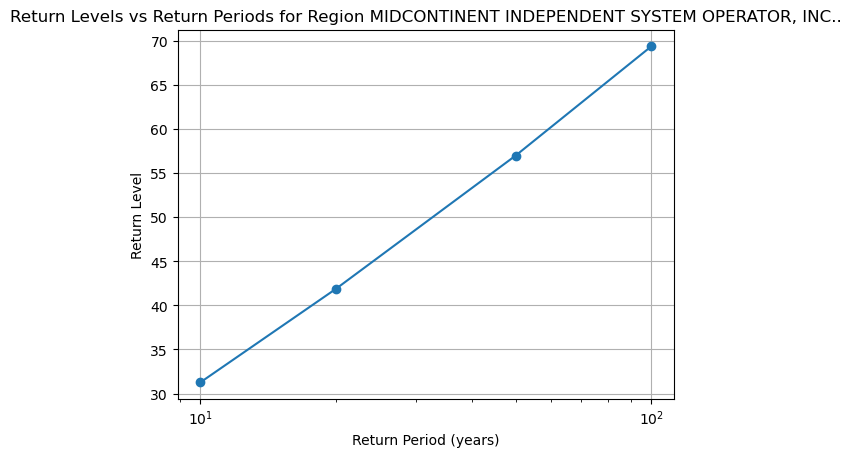

Return Period for region NEW YORK INDEPENDENT SYSTEM OPERATOR: 10 years, Return Level: 14.11
Return Period for region NEW YORK INDEPENDENT SYSTEM OPERATOR: 20 years, Return Level: 17.09
Return Period for region NEW YORK INDEPENDENT SYSTEM OPERATOR: 50 years, Return Level: 20.68
Return Period for region NEW YORK INDEPENDENT SYSTEM OPERATOR: 100 years, Return Level: 23.18


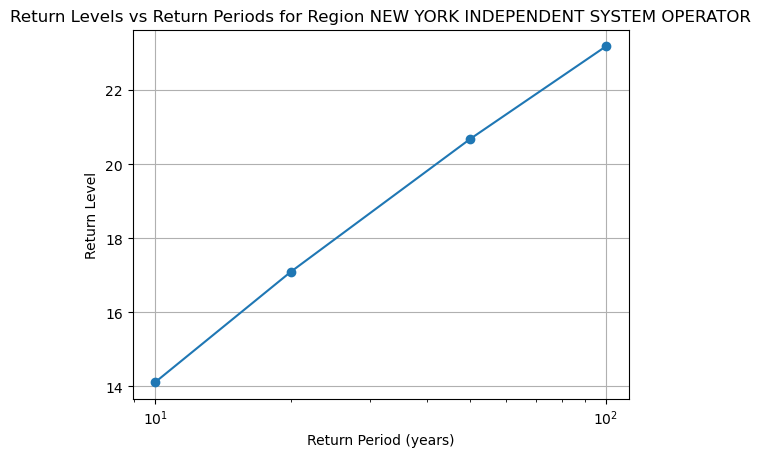

Return Period for region PJM INTERCONNECTION, LLC: 10 years, Return Level: 20.23
Return Period for region PJM INTERCONNECTION, LLC: 20 years, Return Level: 28.28
Return Period for region PJM INTERCONNECTION, LLC: 50 years, Return Level: 41.45
Return Period for region PJM INTERCONNECTION, LLC: 100 years, Return Level: 53.83


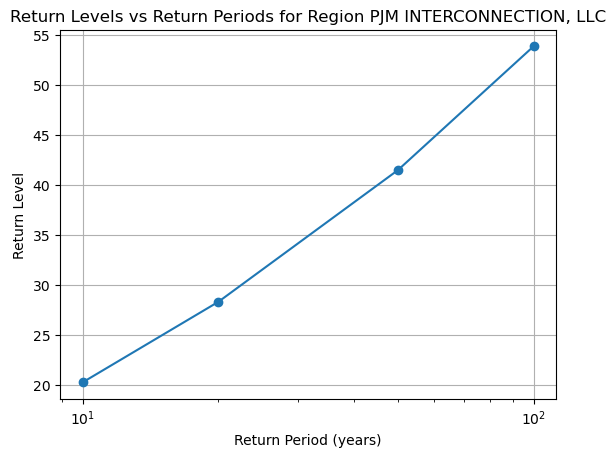

Return Period for region SOUTHERN COMPANY SERVICES, INC.: 10 years, Return Level: 13.70
Return Period for region SOUTHERN COMPANY SERVICES, INC.: 20 years, Return Level: 19.94
Return Period for region SOUTHERN COMPANY SERVICES, INC.: 50 years, Return Level: 30.29
Return Period for region SOUTHERN COMPANY SERVICES, INC.: 100 years, Return Level: 40.16


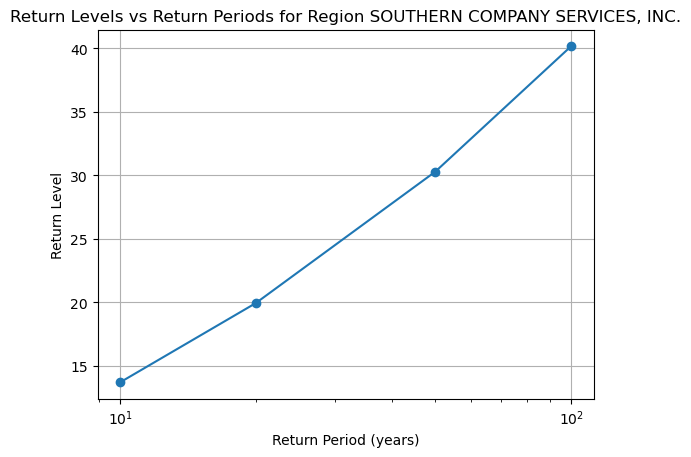

Return Period for region SOUTHWEST POWER POOL: 10 years, Return Level: 18.66
Return Period for region SOUTHWEST POWER POOL: 20 years, Return Level: 29.70
Return Period for region SOUTHWEST POWER POOL: 50 years, Return Level: 51.81
Return Period for region SOUTHWEST POWER POOL: 100 years, Return Level: 77.08


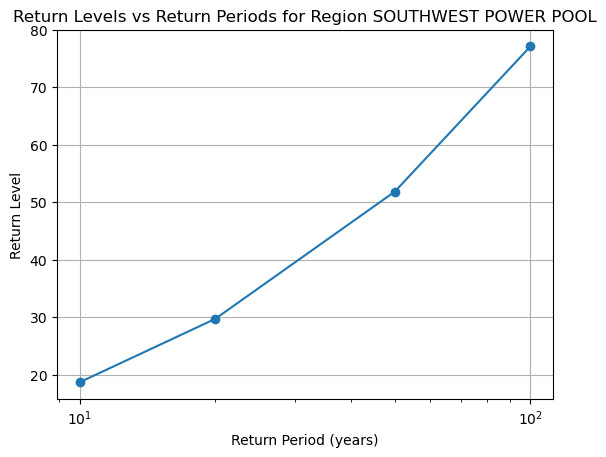

Return Period for region SOUTHWEST POWER POOL WEST: 10 years, Return Level: 32.40
Return Period for region SOUTHWEST POWER POOL WEST: 20 years, Return Level: 32.40
Return Period for region SOUTHWEST POWER POOL WEST: 50 years, Return Level: 32.40
Return Period for region SOUTHWEST POWER POOL WEST: 100 years, Return Level: 32.40


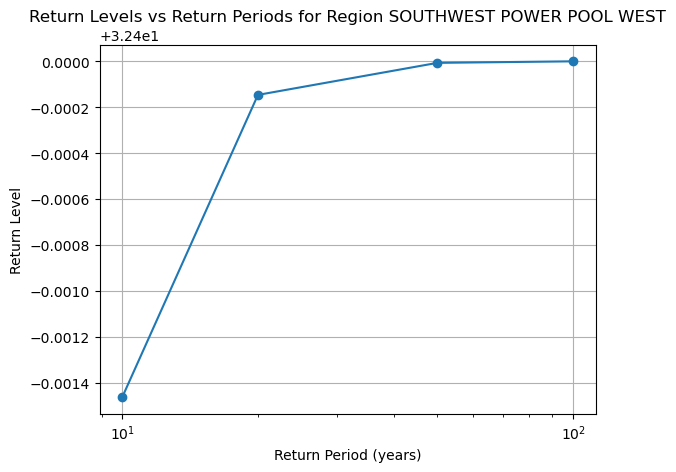

Return Period for region TENNESSEE VALLEY AUTHORITY: 10 years, Return Level: 7.81
Return Period for region TENNESSEE VALLEY AUTHORITY: 20 years, Return Level: 10.34
Return Period for region TENNESSEE VALLEY AUTHORITY: 50 years, Return Level: 14.15
Return Period for region TENNESSEE VALLEY AUTHORITY: 100 years, Return Level: 17.44


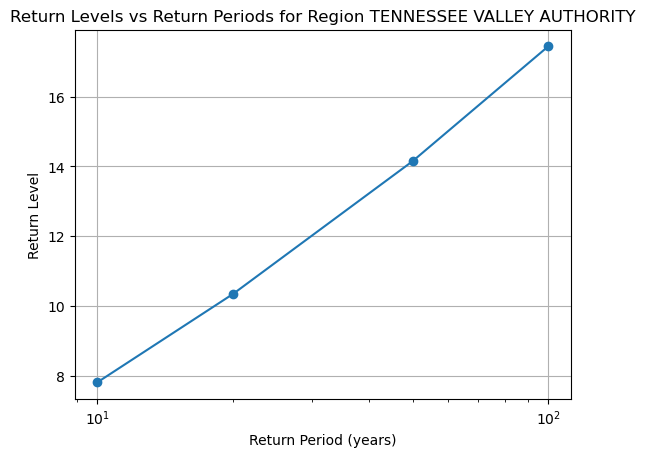

Return Period for region VACAR SOUTH: 10 years, Return Level: 5.27
Return Period for region VACAR SOUTH: 20 years, Return Level: 6.94
Return Period for region VACAR SOUTH: 50 years, Return Level: 9.35
Return Period for region VACAR SOUTH: 100 years, Return Level: 11.37


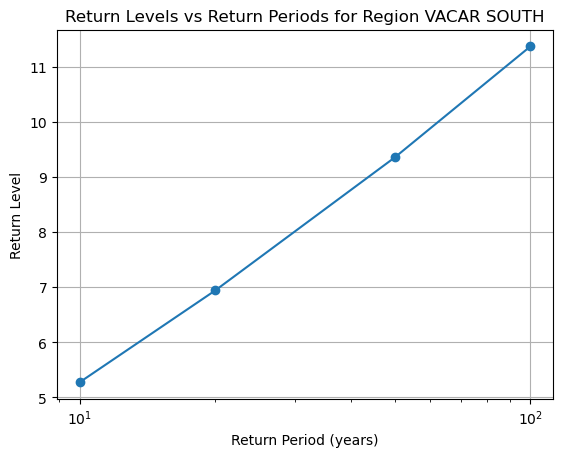

Return Period for region FLORIDA RELIABILITY COORDINATING COUNCIL: 10 years, Return Level: 59.03
Return Period for region FLORIDA RELIABILITY COORDINATING COUNCIL: 20 years, Return Level: 216.14
Return Period for region FLORIDA RELIABILITY COORDINATING COUNCIL: 50 years, Return Level: 1165.86
Return Period for region FLORIDA RELIABILITY COORDINATING COUNCIL: 100 years, Return Level: 4125.80


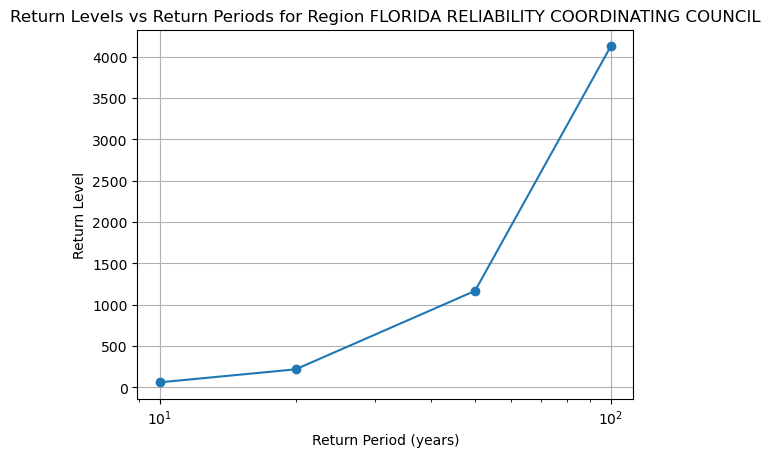

In [34]:
for region, e in extreme_value_fits.items():
    
    # Define return periods (in years)
    return_periods = np.array([10, 20, 50, 100])
    
    # Calculate return levels
    return_levels = genextreme.isf(1 / return_periods, e[0], loc=e[1], scale=e[2])
    
    # Display results
    for rp, rl in zip(return_periods, return_levels):
        print(f"Return Period for region {region}: {rp} years, Return Level: {rl:.2f}")


    plt.figure()
    plt.plot(return_periods, return_levels, marker='o', label='Return Levels')
    plt.title('Return Levels vs Return Periods for Region '+region)
    plt.xlabel('Return Period (years)')
    plt.ylabel('Return Level')
    plt.xscale('log')  # Log scale for better visualization
    plt.grid(True)
    # plt.legend()
    plt.show()

### Bursts analyses

TODO 
- apply the filter for bias and re-analyze these burst results
- 

In [79]:
for r in bursts_events_data:
    print(r)
    print('\t \t {}'.format(bursts_events_data[r].keys()))

CALIFORNIA INDEPENDENT SYSTEM OPERATOR
	 	 dict_keys(['event_start_idxs', 'event_end_idxs', 'event_start_times', 'event_end_times', 'event_sizes', 'event_durations', 'event_betweendistances'])
MIDCONTINENT INDEPENDENT SYSTEM OPERATOR, INC..
	 	 dict_keys(['event_start_idxs', 'event_end_idxs', 'event_start_times', 'event_end_times', 'event_sizes', 'event_durations', 'event_betweendistances'])
SOUTHWEST POWER POOL
	 	 dict_keys(['event_start_idxs', 'event_end_idxs', 'event_start_times', 'event_end_times', 'event_sizes', 'event_durations', 'event_betweendistances'])
PJM INTERCONNECTION, LLC
	 	 dict_keys(['event_start_idxs', 'event_end_idxs', 'event_start_times', 'event_end_times', 'event_sizes', 'event_durations', 'event_betweendistances'])
ERCOT ISO
	 	 dict_keys(['event_start_idxs', 'event_end_idxs', 'event_start_times', 'event_end_times', 'event_sizes', 'event_durations', 'event_betweendistances'])
SOUTHERN COMPANY SERVICES, INC.
	 	 dict_keys(['event_start_idxs', 'event_end_idxs', 'e

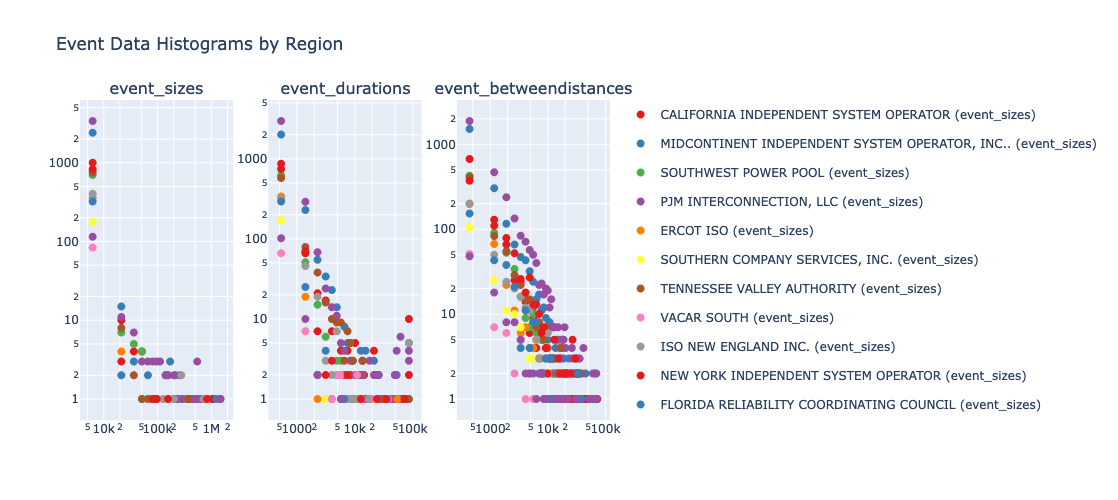

In [90]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Variables for plotting
plot_variables = ['event_sizes', 'event_durations', 'event_betweendistances']
regions = list(bursts_events_data.keys())

# Assign consistent colors to regions using a color palette
color_palette = px.colors.qualitative.Set1
region_colors = {region: color_palette[idx % len(color_palette)] for idx, region in enumerate(regions)}

# Create subplots layout
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=plot_variables
)

bins_dict = {}

# Plot data for each region and variable
for col_idx, var in enumerate(plot_variables, start=1):
    flag_bins = 0
    for region in regions:
        data_points = bursts_events_data[region][var]

        if (flag_bins == 0):
            min_val, max_val = np.nanmin(data_points), np.nanmax(data_points)
            bins_dict[var] = np.linspace(min_val, max_val, num=100)  # Define 100 bins
            flag_bins = 1

        bin_edges = bins_dict[var]

        # Compute histogram frequencies for scatter plotting
        counts, bin_edges = np.histogram(data_points, bins=bin_edges)
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

        # Add scatter plot to the subplot
        fig.add_trace(
            go.Scatter(
                x=bin_centers,
                y=counts,
                mode='markers',#+lines',
                name=f"{region} ({var})",
                legendgroup=f"{region}",  # Link traces across subplots
                marker=dict(size=8, color=region_colors[region]),
                showlegend=True if col_idx == 1 else False
            ),
            row=1, col=col_idx
        )

# Update layout for better interactivity
fig.update_layout(
    title_text="Event Data Histograms by Region",
    height=500,
    width=1200,
    showlegend=True
)

# Set log axes for all subplots
for i in range(1, 4):
    fig.update_xaxes(type='log', row=1, col=i)
    fig.update_yaxes(type='log', row=1, col=i)




fig.show()



<Axes: >

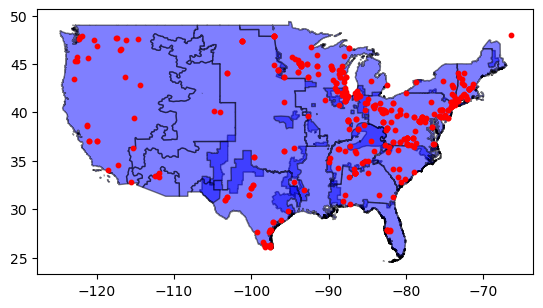

In [62]:
ax = regions_gdf.plot(color="blue", alpha=0.5, edgecolor="black")
sensor_locations_with_regions.plot(ax=ax, color="red", markersize=10)